In [1]:
import os

import random

from __future__ import absolute_import, division, print_function, unicode_literals
import sys
print("Python executable:", sys.executable)
import tensorflow as tf
tf.config.experimental.enable_op_determinism()
print("TF 版本:", tf.__version__)
print("CUDA 版本:", tf.sysconfig.get_build_info().get("cuda_version"))
print("cuDNN 版本:", tf.sysconfig.get_build_info().get("cudnn_version"))

import tensorflow as tf; tf.config.list_physical_devices('GPU')
print("可用 GPU 设备:", tf.config.list_physical_devices('GPU'))
from tensorflow.keras import datasets, layers, models, Model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import cv2
print("OpenCV 版本:", cv2.__version__)
from matplotlib import pyplot
import h5py
from tensorflow.keras.utils import img_to_array
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Python executable: E:\Anaconda3\python.exe
TF 版本: 2.18.0
CUDA 版本: None
cuDNN 版本: None
可用 GPU 设备: []
OpenCV 版本: 4.11.0


In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0


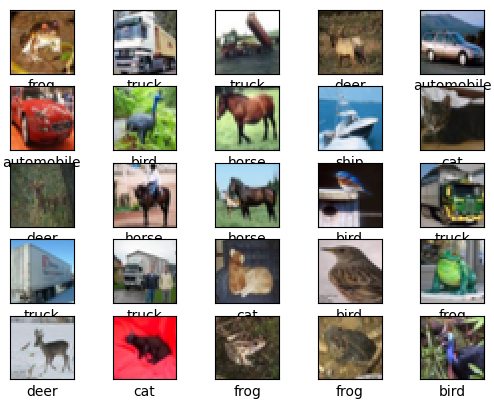

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(25):
    plt.subplot(5, 5, i + 1)  
    plt.xticks([])  
    plt.yticks([]) 
    plt.grid(False)  #
    plt.imshow(train_images[i])  
    plt.xlabel(class_names[train_labels[i][0]])  

plt.show() 

In [4]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.config.experimental.enable_op_determinism()

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """Build a unit of stacked convolution layer + Batch Normalization + activation, using an L2 regularization coefficient of 1e-3."""
    conv = layers.Conv2D(num_filters,
                         kernel_size=kernel_size,
                         strides=strides,
                         padding='same',
                         kernel_initializer='he_normal',
                         kernel_regularizer=regularizers.l2(1e-3))
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v1(input_shape, depth, num_classes=10, dropout_rate=0.0):
    """
    Build the ResNet V1 model, suitable for CIFAR-10.
    The depth must satisfy 6n+2, e.g., ResNet-20 corresponds to n=3.
    dropout_rate: the dropout ratio applied after each residual block.
    """
    if (depth - 2) % 6 != 0:
        raise ValueError("Depth must satisfy 6n+2 (e.g., 20, 32, 44, 56, 110)")
    num_filters = 16
    num_res_blocks = (depth - 2) // 6

    inputs = layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs, num_filters=num_filters)

    # Three stacks, each containing num_res_blocks residual blocks.
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # Downsampling is performed in the first residual block of each non-first stack.
            if stack > 0 and res_block == 0:
                strides = 2
            # Residual block: two consecutive convolution layers.
            y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
            # Adjust the dimensions of x if downsampling is required.
            if stack > 0 and res_block == 0:
                x = resnet_layer(inputs=x, num_filters=num_filters, kernel_size=1,
                                 strides=strides, activation=None, batch_normalization=False)
            # Residual connection.
            x = layers.add([x, y])
            x = layers.Activation('relu')(x)
            # Add Dropout after each residual block.
            if dropout_rate > 0:
                x = layers.Dropout(dropout_rate)(x)
        # Add an extra Dropout after each stack.
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate)(x)
        num_filters *= 2

    # Classifier part: Global Average Pooling -> Flatten -> heavy Dropout -> Fully Connected layer.
    x = layers.AveragePooling2D(pool_size=8)(x)
    y = layers.Flatten()(x)
    y = layers.Dropout(0.5)(y)  # Heavy Dropout before the classifier.
    outputs = layers.Dense(num_classes,
                           activation='softmax',
                           kernel_initializer='he_normal')(y)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Model parameter settings.
input_shape = (32, 32, 3)
depth = 20       # For ResNet-20, 6*3+2=20.
num_classes = 10
dropout_rate = 0.4  # Increase Dropout to 40%.

# Load the CIFAR-10 dataset and normalize the pixel values.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

# Convert labels to one-hot encoding and apply label smoothing (kept at 0.1 here).
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test  = tf.keras.utils.to_categorical(y_test, num_classes)

# Data augmentation: add rotation, shift, zoom, and horizontal flip.
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='reflect'
)
datagen.fit(x_train)

# Build the ResNet-20 model with strong regularization measures.
model = resnet_v1(input_shape=input_shape, depth=depth, num_classes=num_classes, dropout_rate=dropout_rate)

# Use the label-smoothed cross-entropy loss function.
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
# Set the optimizer's initial learning rate to 0.001.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=loss_fn,
              metrics=['accuracy'])


In [5]:
#Pour afficher l'architecture du modele CNN
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 32, 32, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 32, 32, 16)        │             448 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 32, 32, 16)        │              64 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 32, 32, 16)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 32, 32, 16)        │           2,320 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 32, 32, 16)        │              64 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 32, 32, 16)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 32, 32, 16)        │           2,320 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 32, 32, 16)        │              64 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 32, 32, 16)        │               0 │ activation[0][0],          │
│                               │                           │                 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 32, 32, 16)        │               0 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 32, 32, 16)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 32, 32, 16)        │           2,320 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 32, 32, 16)        │              64 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 32, 32, 16)        │               

 Total params: 274,442 (1.05 MB)

 Trainable params: 273,066 (1.04 MB)

 Non-trainable params: 1,376 (5.38 KB)

In [6]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-7, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=60, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint("resnet20_cifar10_best.h5", monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(datagen.flow(x_train, y_train, batch_size=128),
                    epochs=300,
                    validation_data=(x_test, y_test),
                    callbacks=[reduce_lr, early_stop, checkpoint],
                    shuffle=True)

model.save(r"C:\Users\Clay\Desktop\MN\Biometric\TP-CNN\model\resnet20V3.h5")


Epoch 1/300


E:\Anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.1216 - loss: 7.7659
Epoch 1: val_loss improved from inf to 3.76770, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 209ms/step - accuracy: 0.1217 - loss: 7.7588 - val_accuracy: 0.0951 - val_loss: 3.7677 - learning_rate: 0.0010
Epoch 2/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.1819 - loss: 3.1736
Epoch 2: val_loss did not improve from 3.76770
391/391 ━━━━━━━━━━━━━━━━━━━━ 86s 219ms/step - accuracy: 0.1820 - loss: 3.1733 - val_accuracy: 0.1001 - val_loss: 3.7715 - learning_rate: 0.0010
Epoch 3/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.2150 - loss: 2.7294
Epoch 3: val_loss improved from 3.76770 to 3.10031, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 85s 217ms/step - accuracy: 0.2151 - loss: 2.7292 - val_accuracy: 0.1078 - val_loss: 3.1003 - learning_rate: 0.0010
Epoch 4/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.2513 - loss: 2.4653
Epoch 4: val_loss improved from 3.10031 to 2.84709, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 85s 217ms/step - accuracy: 0.2513 - loss: 2.4652 - val_accuracy: 0.1244 - val_loss: 2.8471 - learning_rate: 0.0010
Epoch 5/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.2830 - loss: 2.3039
Epoch 5: val_loss improved from 2.84709 to 2.47730, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 85s 218ms/step - accuracy: 0.2830 - loss: 2.3038 - val_accuracy: 0.1998 - val_loss: 2.4773 - learning_rate: 0.0010
Epoch 6/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.3186 - loss: 2.1750
Epoch 6: val_loss did not improve from 2.47730
391/391 ━━━━━━━━━━━━━━━━━━━━ 84s 216ms/step - accuracy: 0.3186 - loss: 2.1750 - val_accuracy: 0.1393 - val_loss: 2.9210 - learning_rate: 0.0010
Epoch 7/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.3515 - loss: 2.0839
Epoch 7: val_loss improved from 2.47730 to 2.36624, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 84s 216ms/step - accuracy: 0.3515 - loss: 2.0839 - val_accuracy: 0.2241 - val_loss: 2.3662 - learning_rate: 0.0010
Epoch 8/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.3755 - loss: 2.0067
Epoch 8: val_loss improved from 2.36624 to 1.91085, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 85s 217ms/step - accuracy: 0.3755 - loss: 2.0067 - val_accuracy: 0.3974 - val_loss: 1.9109 - learning_rate: 0.0010
Epoch 9/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.4005 - loss: 1.9464
Epoch 9: val_loss did not improve from 1.91085
391/391 ━━━━━━━━━━━━━━━━━━━━ 85s 218ms/step - accuracy: 0.4005 - loss: 1.9464 - val_accuracy: 0.3136 - val_loss: 2.2264 - learning_rate: 0.0010
Epoch 10/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.4293 - loss: 1.8901
Epoch 10: val_loss did not improve from 1.91085
391/391 ━━━━━━━━━━━━━━━━━━━━ 87s 222ms/step - accuracy: 0.4293 - loss: 1.8901 - val_accuracy: 0.3993 - val_loss: 1.9366 - learning_rate: 0.0010
Epoch 11/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.4510 - loss: 1.8435
Epoch 11: val_loss did not improve from 1.91085
391/391 ━━━━━━━━━━━━━━━━━━━━ 87s 222ms/step - accuracy: 0.4510 - loss: 1.8434 - val_accuracy: 0.3770 - val_loss: 1.9843 - learning_rate: 0.0010
Epoch 12/300

391/391 ━━━━━━━━━━━━━━━━━━━━ 86s 220ms/step - accuracy: 0.4634 - loss: 1.8175 - val_accuracy: 0.4940 - val_loss: 1.7333 - learning_rate: 0.0010
Epoch 13/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.4854 - loss: 1.7681
Epoch 13: val_loss improved from 1.73330 to 1.71129, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 85s 218ms/step - accuracy: 0.4854 - loss: 1.7681 - val_accuracy: 0.4947 - val_loss: 1.7113 - learning_rate: 0.0010
Epoch 14/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5007 - loss: 1.7399
Epoch 14: val_loss did not improve from 1.71129
391/391 ━━━━━━━━━━━━━━━━━━━━ 85s 217ms/step - accuracy: 0.5007 - loss: 1.7399 - val_accuracy: 0.4861 - val_loss: 1.7493 - learning_rate: 0.0010
Epoch 15/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5102 - loss: 1.7189
Epoch 15: val_loss improved from 1.71129 to 1.71127, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 85s 217ms/step - accuracy: 0.5102 - loss: 1.7189 - val_accuracy: 0.5118 - val_loss: 1.7113 - learning_rate: 0.0010
Epoch 16/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5229 - loss: 1.6943
Epoch 16: val_loss improved from 1.71127 to 1.62823, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 85s 217ms/step - accuracy: 0.5229 - loss: 1.6943 - val_accuracy: 0.5406 - val_loss: 1.6282 - learning_rate: 0.0010
Epoch 17/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5315 - loss: 1.6769
Epoch 17: val_loss did not improve from 1.62823
391/391 ━━━━━━━━━━━━━━━━━━━━ 85s 217ms/step - accuracy: 0.5315 - loss: 1.6769 - val_accuracy: 0.3474 - val_loss: 2.4407 - learning_rate: 0.0010
Epoch 18/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.5358 - loss: 1.6680
Epoch 18: val_loss did not improve from 1.62823
391/391 ━━━━━━━━━━━━━━━━━━━━ 85s 217ms/step - accuracy: 0.5358 - loss: 1.6680 - val_accuracy: 0.4899 - val_loss: 1.7392 - learning_rate: 0.0010
Epoch 19/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.5463 - loss: 1.6474
Epoch 19: val_loss did not improve from 1.62823
391/391 ━━━━━━━━━━━━━━━━━━━━ 85s 218ms/step - accuracy: 0.5463 - loss: 1.6474 - val_accuracy: 0.4740 - val_loss: 1.8887 - learning_rate: 0.0010
Epoch 20/3

391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 230ms/step - accuracy: 0.5622 - loss: 1.6216 - val_accuracy: 0.5583 - val_loss: 1.5785 - learning_rate: 0.0010
Epoch 23/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5590 - loss: 1.6209
Epoch 23: val_loss improved from 1.57848 to 1.55315, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 92s 237ms/step - accuracy: 0.5590 - loss: 1.6209 - val_accuracy: 0.5702 - val_loss: 1.5531 - learning_rate: 0.0010
Epoch 24/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.5728 - loss: 1.6100
Epoch 24: val_loss did not improve from 1.55315
391/391 ━━━━━━━━━━━━━━━━━━━━ 93s 239ms/step - accuracy: 0.5728 - loss: 1.6100 - val_accuracy: 0.5736 - val_loss: 1.5667 - learning_rate: 0.0010
Epoch 25/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5778 - loss: 1.5898
Epoch 25: val_loss did not improve from 1.55315
391/391 ━━━━━━━━━━━━━━━━━━━━ 94s 239ms/step - accuracy: 0.5778 - loss: 1.5898 - val_accuracy: 0.5164 - val_loss: 1.7828 - learning_rate: 0.0010
Epoch 26/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5822 - loss: 1.5837
Epoch 26: val_loss did not improve from 1.55315
391/391 ━━━━━━━━━━━━━━━━━━━━ 92s 236ms/step - accuracy: 0.5822 - loss: 1.5837 - val_accuracy: 0.4766 - val_loss: 1.9156 - learning_rate: 0.0010
Epoch 27/3

391/391 ━━━━━━━━━━━━━━━━━━━━ 92s 236ms/step - accuracy: 0.5915 - loss: 1.5625 - val_accuracy: 0.6072 - val_loss: 1.4892 - learning_rate: 0.0010
Epoch 30/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5971 - loss: 1.5600
Epoch 30: val_loss did not improve from 1.48924
391/391 ━━━━━━━━━━━━━━━━━━━━ 92s 235ms/step - accuracy: 0.5971 - loss: 1.5600 - val_accuracy: 0.5380 - val_loss: 1.6594 - learning_rate: 0.0010
Epoch 31/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6004 - loss: 1.5495
Epoch 31: val_loss did not improve from 1.48924
391/391 ━━━━━━━━━━━━━━━━━━━━ 91s 234ms/step - accuracy: 0.6004 - loss: 1.5495 - val_accuracy: 0.5616 - val_loss: 1.5852 - learning_rate: 0.0010
Epoch 32/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.6039 - loss: 1.5473
Epoch 32: val_loss did not improve from 1.48924
391/391 ━━━━━━━━━━━━━━━━━━━━ 94s 240ms/step - accuracy: 0.6039 - loss: 1.5473 - val_accuracy: 0.6041 - val_loss: 1.4935 - learning_rate: 0.0010
Epoch 33/3

391/391 ━━━━━━━━━━━━━━━━━━━━ 85s 218ms/step - accuracy: 0.6240 - loss: 1.5100 - val_accuracy: 0.6316 - val_loss: 1.4510 - learning_rate: 0.0010
Epoch 42/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6239 - loss: 1.5065
Epoch 42: val_loss did not improve from 1.45099
391/391 ━━━━━━━━━━━━━━━━━━━━ 85s 217ms/step - accuracy: 0.6239 - loss: 1.5065 - val_accuracy: 0.6224 - val_loss: 1.4899 - learning_rate: 0.0010
Epoch 43/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6225 - loss: 1.5140
Epoch 43: val_loss did not improve from 1.45099
391/391 ━━━━━━━━━━━━━━━━━━━━ 86s 219ms/step - accuracy: 0.6225 - loss: 1.5140 - val_accuracy: 0.5554 - val_loss: 1.7404 - learning_rate: 0.0010
Epoch 44/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6241 - loss: 1.5075
Epoch 44: val_loss improved from 1.45099 to 1.38381, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 85s 218ms/step - accuracy: 0.6241 - loss: 1.5075 - val_accuracy: 0.6631 - val_loss: 1.3838 - learning_rate: 0.0010
Epoch 45/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6317 - loss: 1.4954
Epoch 45: val_loss did not improve from 1.38381
391/391 ━━━━━━━━━━━━━━━━━━━━ 85s 218ms/step - accuracy: 0.6317 - loss: 1.4954 - val_accuracy: 0.5418 - val_loss: 1.6717 - learning_rate: 0.0010
Epoch 46/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.6250 - loss: 1.5091
Epoch 46: val_loss did not improve from 1.38381
391/391 ━━━━━━━━━━━━━━━━━━━━ 86s 220ms/step - accuracy: 0.6250 - loss: 1.5090 - val_accuracy: 0.5652 - val_loss: 1.6515 - learning_rate: 0.0010
Epoch 47/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6284 - loss: 1.4969
Epoch 47: val_loss did not improve from 1.38381
391/391 ━━━━━━━━━━━━━━━━━━━━ 85s 216ms/step - accuracy: 0.6284 - loss: 1.4969 - val_accuracy: 0.5136 - val_loss: 1.7467 - learning_rate: 0.0010
Epoch 48/3

391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 227ms/step - accuracy: 0.6741 - loss: 1.3929 - val_accuracy: 0.6644 - val_loss: 1.3618 - learning_rate: 5.0000e-04
Epoch 72/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.6762 - loss: 1.3874
Epoch 72: val_loss did not improve from 1.36181
391/391 ━━━━━━━━━━━━━━━━━━━━ 93s 237ms/step - accuracy: 0.6762 - loss: 1.3873 - val_accuracy: 0.6547 - val_loss: 1.3765 - learning_rate: 5.0000e-04
Epoch 73/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.6785 - loss: 1.3820
Epoch 73: val_loss did not improve from 1.36181
391/391 ━━━━━━━━━━━━━━━━━━━━ 96s 245ms/step - accuracy: 0.6784 - loss: 1.3820 - val_accuracy: 0.6642 - val_loss: 1.3961 - learning_rate: 5.0000e-04
Epoch 74/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.6767 - loss: 1.3826
Epoch 74: val_loss did not improve from 1.36181
391/391 ━━━━━━━━━━━━━━━━━━━━ 91s 233ms/step - accuracy: 0.6767 - loss: 1.3826 - val_accuracy: 0.6608 - val_loss: 1.3844 - learning_rate: 5.000

391/391 ━━━━━━━━━━━━━━━━━━━━ 91s 232ms/step - accuracy: 0.6770 - loss: 1.3809 - val_accuracy: 0.6602 - val_loss: 1.3500 - learning_rate: 5.0000e-04
Epoch 76/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6798 - loss: 1.3809
Epoch 76: val_loss did not improve from 1.35001
391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 229ms/step - accuracy: 0.6798 - loss: 1.3809 - val_accuracy: 0.6130 - val_loss: 1.4961 - learning_rate: 5.0000e-04
Epoch 77/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.6866 - loss: 1.3650
Epoch 77: val_loss did not improve from 1.35001
391/391 ━━━━━━━━━━━━━━━━━━━━ 88s 224ms/step - accuracy: 0.6866 - loss: 1.3650 - val_accuracy: 0.6154 - val_loss: 1.4542 - learning_rate: 5.0000e-04
Epoch 78/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.6796 - loss: 1.3716
Epoch 78: val_loss improved from 1.35001 to 1.28663, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 89s 227ms/step - accuracy: 0.6796 - loss: 1.3716 - val_accuracy: 0.6942 - val_loss: 1.2866 - learning_rate: 5.0000e-04
Epoch 79/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6820 - loss: 1.3675
Epoch 79: val_loss did not improve from 1.28663
391/391 ━━━━━━━━━━━━━━━━━━━━ 88s 225ms/step - accuracy: 0.6820 - loss: 1.3675 - val_accuracy: 0.6986 - val_loss: 1.2942 - learning_rate: 5.0000e-04
Epoch 80/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6808 - loss: 1.3674
Epoch 80: val_loss did not improve from 1.28663
391/391 ━━━━━━━━━━━━━━━━━━━━ 88s 225ms/step - accuracy: 0.6808 - loss: 1.3674 - val_accuracy: 0.5963 - val_loss: 1.5545 - learning_rate: 5.0000e-04
Epoch 81/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6842 - loss: 1.3662
Epoch 81: val_loss did not improve from 1.28663
391/391 ━━━━━━━━━━━━━━━━━━━━ 91s 233ms/step - accuracy: 0.6842 - loss: 1.3662 - val_accuracy: 0.6525 - val_loss: 1.4070 - learning_rate: 5.000

391/391 ━━━━━━━━━━━━━━━━━━━━ 86s 220ms/step - accuracy: 0.6903 - loss: 1.3588 - val_accuracy: 0.7055 - val_loss: 1.2656 - learning_rate: 5.0000e-04
Epoch 95/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.6944 - loss: 1.3525
Epoch 95: val_loss did not improve from 1.26558
391/391 ━━━━━━━━━━━━━━━━━━━━ 86s 220ms/step - accuracy: 0.6944 - loss: 1.3525 - val_accuracy: 0.6313 - val_loss: 1.4988 - learning_rate: 5.0000e-04
Epoch 96/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6886 - loss: 1.3528
Epoch 96: val_loss improved from 1.26558 to 1.25111, saving model to resnet20_cifar10_best.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 86s 220ms/step - accuracy: 0.6886 - loss: 1.3528 - val_accuracy: 0.7140 - val_loss: 1.2511 - learning_rate: 5.0000e-04
Epoch 97/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6981 - loss: 1.3429
Epoch 97: val_loss did not improve from 1.25111
391/391 ━━━━━━━━━━━━━━━━━━━━ 86s 219ms/step - accuracy: 0.6981 - loss: 1.3429 - val_accuracy: 0.5269 - val_loss: 1.8789 - learning_rate: 5.0000e-04
Epoch 98/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6898 - loss: 1.3543
Epoch 98: val_loss did not improve from 1.25111
391/391 ━━━━━━━━━━━━━━━━━━━━ 86s 220ms/step - accuracy: 0.6898 - loss: 1.3543 - val_accuracy: 0.6839 - val_loss: 1.3422 - learning_rate: 5.0000e-04
Epoch 99/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6911 - loss: 1.3480
Epoch 99: val_loss did not improve from 1.25111
391/391 ━━━━━━━━━━━━━━━━━━━━ 86s 219ms/step - accuracy: 0.6911 - loss: 1.3481 - val_accuracy: 0.6448 - val_loss: 1.3965 - learning_rate: 5.000

391/391 ━━━━━━━━━━━━━━━━━━━━ 92s 234ms/step - accuracy: 0.6917 - loss: 1.3470 - val_accuracy: 0.7210 - val_loss: 1.2265 - learning_rate: 5.0000e-04
Epoch 107/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.6992 - loss: 1.3402
Epoch 107: val_loss did not improve from 1.22653
391/391 ━━━━━━━━━━━━━━━━━━━━ 88s 225ms/step - accuracy: 0.6992 - loss: 1.3402 - val_accuracy: 0.6616 - val_loss: 1.3950 - learning_rate: 5.0000e-04
Epoch 108/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6969 - loss: 1.3418
Epoch 108: val_loss did not improve from 1.22653
391/391 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - accuracy: 0.6969 - loss: 1.3418 - val_accuracy: 0.6820 - val_loss: 1.3343 - learning_rate: 5.0000e-04
Epoch 109/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.6981 - loss: 1.3391
Epoch 109: val_loss did not improve from 1.22653
391/391 ━━━━━━━━━━━━━━━━━━━━ 92s 236ms/step - accuracy: 0.6981 - loss: 1.3391 - val_accuracy: 0.6469 - val_loss: 1.3984 - learning_rate:

391/391 ━━━━━━━━━━━━━━━━━━━━ 86s 221ms/step - accuracy: 0.7205 - loss: 1.2887 - val_accuracy: 0.7363 - val_loss: 1.1935 - learning_rate: 2.5000e-04
Epoch 129/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.7235 - loss: 1.2772
Epoch 129: val_loss did not improve from 1.19350
391/391 ━━━━━━━━━━━━━━━━━━━━ 86s 219ms/step - accuracy: 0.7235 - loss: 1.2773 - val_accuracy: 0.6632 - val_loss: 1.4211 - learning_rate: 2.5000e-04
Epoch 130/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.7240 - loss: 1.2824
Epoch 130: val_loss did not improve from 1.19350
391/391 ━━━━━━━━━━━━━━━━━━━━ 86s 219ms/step - accuracy: 0.7240 - loss: 1.2824 - val_accuracy: 0.6978 - val_loss: 1.3153 - learning_rate: 2.5000e-04
Epoch 131/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.7208 - loss: 1.2795
Epoch 131: val_loss did not improve from 1.19350
391/391 ━━━━━━━━━━━━━━━━━━━━ 86s 220ms/step - accuracy: 0.7208 - loss: 1.2795 - val_accuracy: 0.6538 - val_loss: 1.4488 - learning_rate:

KeyboardInterrupt: 

In [7]:
model.save(r"C:\Users\Clay\Desktop\MN\Biometric\TP-CNN\model\resnet20V3.h5")

In [8]:
model=load_model(r"C:\Users\Clay\Desktop\MN\Biometric\TP-CNN\model\\resnet20V3.h5")

In [9]:
train_acc = history.history['accuracy'][-1]
test_acc  = history.history['val_accuracy'][-1]

# （accuracy vs epochs）
plt.plot(history.history['accuracy'],
         label=f"Train_accuracy (ep144={train_acc:.4f})")  
plt.plot(history.history['val_accuracy'],
         label=f"Test_accuracy (ep144={test_acc:.4f})")   
plt.xlabel('Epoch')  
plt.ylabel('Accuracy') 
plt.ylim([0.5, 1])  
plt.title('ResNet20_V3 Accuracy in 144 Epoch') 
plt.legend(loc='lower right')  

plt.savefig(r'C:\Users\Clay\Desktop\MN\Biometric\TP-CNN\training history\ResNet20_V3_144Epoch.png') 
plt.show() 


NameError: name 'history' is not defined

In [10]:

import pandas as pd

history_dict = history.history

df = pd.DataFrame({
    "Train_accuracy": history_dict["accuracy"],
    "Train_loss": history_dict["loss"],
    "Test_accuracy": history_dict["val_accuracy"],
    "Test_loss": history_dict["val_loss"]
})

excel_filename = "training_history.xlsx"
df.to_excel(excel_filename, index=False)

df_history = pd.DataFrame(history.history)
df_history.to_csv('history.csv', index=False)


In [11]:
print(test_acc)

0.8094000220298767


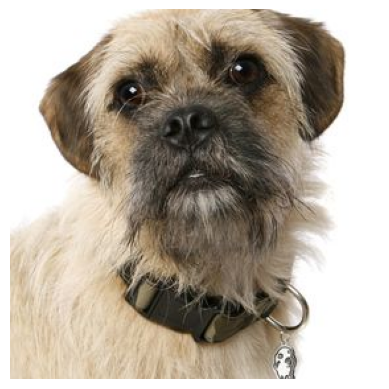

In [12]:

img = cv2.imread(r"C:\Users\Clay\Desktop\MN\Biometric\TP-CNN\chien.jpg") 

img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_cvt)
plt.axis('off') 
plt.show()


In [13]:

img = cv2.resize(img_cvt, (32,32))
img = img.astype('float32')
img= img / 255.0
imgs = tf.expand_dims(
    img,
    axis=0,
    name=None
)
model.predict(imgs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


array([[7.7678938e-04, 1.1821933e-04, 3.3406934e-01, 1.5689982e-02,
        1.9137417e-01, 3.5414450e-02, 4.2080915e-01, 1.6461476e-03,
        1.5055811e-05, 8.6745706e-05]], dtype=float32)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 896 (3.50 KB)

 Trainable params: 896 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


C:\Users\MI\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 32, 32, 3))
  warnings.warn(msg)


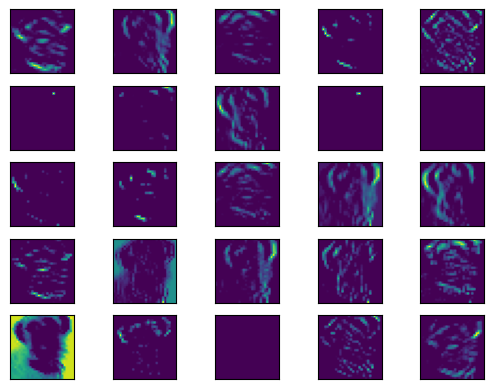

In [45]:


i=4


square = 5
ix = 1

model2 = Model(inputs=model.inputs, outputs=model.layers[i].output)

model2.summary()

feature_maps = model2.predict(imgs)
    
for _ in range(square):
  for _ in range(square):
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])  
        ax.set_yticks([]) 
        
        pyplot.imshow(feature_maps[0, :, :, ix-1])

        ix += 1

pyplot.show()
